In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import random as rd
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
import os
import tensorflow as tf
from tqdm import tqdm

In [2]:
data = pd.read_csv('./dataset/winequality-red-dot.csv')
y = data.quality                  # set 'quality' as target
X = data.drop('quality', axis=1)  # rest are features
print(y.shape, X.shape)           # check correctness.csv')
data.head()

(1599,) (1599, 11)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


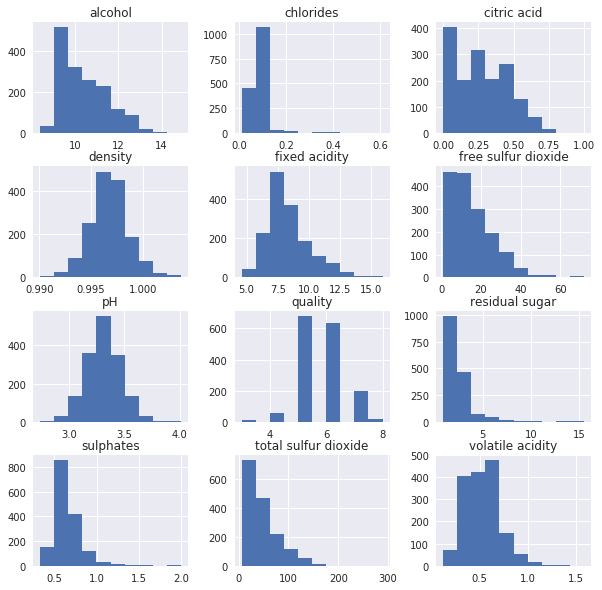

In [3]:
sns.set()
data.hist(figsize=(10,10))
plt.show()

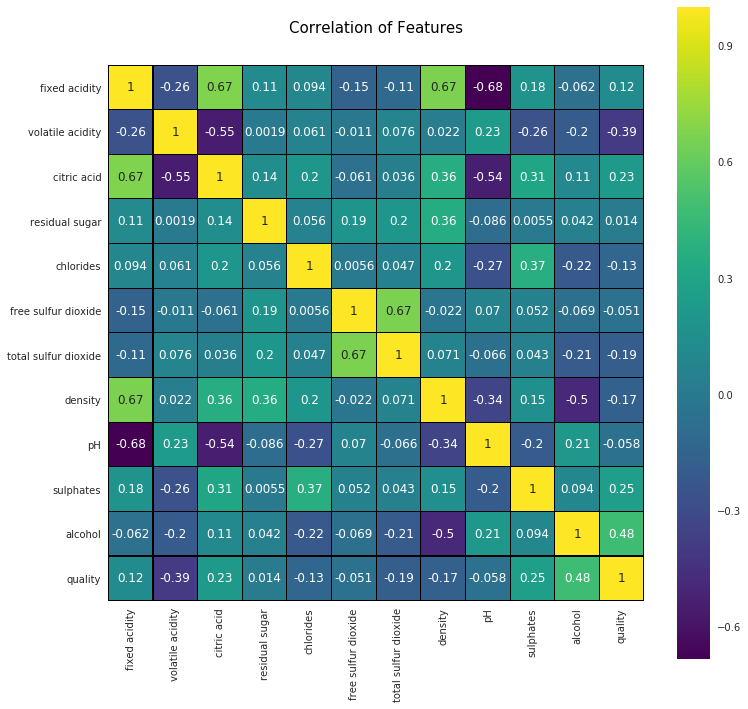

In [4]:
colormap = plt.cm.viridis
plt.figure(figsize=(12, 12))
plt.title('Correlation of Features', y=1.05, size=15, color="black")
sns.heatmap(data.astype(float).corr(), linewidths=0.1, vmax=1.0, square=True, cmap=colormap, linecolor='black', annot=True)
plt.show()

In [5]:
def preprocess():
    dataset = pd.read_csv("./dataset/winequality-red-dot.csv")
    #Normalize
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(dataset)
    a = pd.DataFrame(x_scaled, columns=dataset.columns)
    a.drop('quality', axis=1, inplace=True)

    # split train and test set
    quality = list(dataset['quality'])
    train, test = train_test_split(a, test_size=0.1, random_state=42)
    train_q, test_q = train_test_split(quality, test_size=0.1, random_state=42)
    return train, test, train_q, test_q


# tensorflow add layer
def add_layer(inputs, input_tensors, output_tensors, activation_function=None):
    w = tf.Variable(tf.random_normal([input_tensors, output_tensors]))
    b = tf.Variable(tf.truncated_normal([output_tensors]))
    formula = tf.add(tf.matmul(inputs, w), b)  # matmul = dot
    if activation_function is None:
        outputs = formula
    else:
        outputs = activation_function(formula)
    return outputs

train_data, test_data, train_y, test_y = preprocess()

In [6]:
INPUT = len(train_data.values[0]) #11
HIDDEN = 5
OUTPUT = 6

y_feed = tf.placeholder(tf.int32, [1])  # no:0 yes:1
y_hat = tf.one_hot((y_feed-3), OUTPUT)  # 3~8 => 0~5
x_feed = tf.placeholder(tf.float32, [None, INPUT])

In [7]:
# hidden_layer 1
w1 = tf.Variable(tf.random_uniform([INPUT, 4], minval=-1, maxval=1))
b1 = tf.Variable(tf.random_uniform([4], minval=-1, maxval=1))
formula1 = tf.add(tf.matmul(x_feed, w1), b1)  # matmul = dot
hidden_layer1 = tf.nn.sigmoid(formula1)
# hidden_layer 2
w2 = tf.Variable(tf.random_uniform([4, HIDDEN], minval=-1, maxval=1))
b2 = tf.Variable(tf.random_uniform([HIDDEN], minval=-1, maxval=1))
formula2 = tf.add(tf.matmul(hidden_layer1, w2), b2)  # matmul = dot
hidden_layer2 = tf.nn.sigmoid(formula2)
# output
w3 = tf.Variable(tf.random_uniform([HIDDEN, OUTPUT], minval=-1, maxval=1))
b3 = tf.Variable(tf.random_uniform([OUTPUT], minval=-1, maxval=1))
output_formula = tf.add(tf.matmul(hidden_layer2, w3), b3)  # matmul = dot
output_layer = tf.nn.softmax(output_formula)

loss = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(labels=y_hat, logits=output_layer))   # loss function use cross entropy
# loss = tf.losses.mean_squared_error(y_hat, output_layer)
optimizer = tf.train.AdagradOptimizer(learning_rate=0.1)
train = optimizer.minimize(loss)

# Accuracy if argmax(output_layer) == label: return 1
correct_prediction = tf.equal(tf.argmax(output_layer, 1), tf.argmax(y_hat, 1))
acc = tf.cast(correct_prediction, tf.float32)


init = tf.global_variables_initializer()
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.3)
sess = tf.Session(config=tf.ConfigProto(
  allow_soft_placement=True, log_device_placement=False, gpu_options=gpu_options))
sess.run(init)

In [8]:
print('training')

data_num = len(train_data.values)
test_num = len(test_data.values)

list_train_acc = []
list_test_acc = []
list_train_kaggle_acc = []
list_test_kaggle_acc = []

for iteration in tqdm(range(100000)):
    cost_total = 0  # loss score
    acc_total = 0  # train set accuracy
    quality_acc = 0  # train set kaggle accuracy
    train_prediction_list = []
    for pid, point in enumerate(train_data.values):
        _,cost, output_acc, train_prediction = sess.run([train ,loss, acc, output_layer], feed_dict={x_feed: [point], y_feed: [train_y[pid]]})

        # accuracy
        cost_total += cost
        acc_total += output_acc

        # kaggle accuracy
        train_prediction = np.argmax(train_prediction)
        train_prediction_list.append(train_prediction + 3)
        if train_prediction > 2 and train_y[pid] - 3 > 2:
            quality_acc += 1
        elif train_prediction <= 2 and train_y[pid] - 3 <= 2:
            quality_acc += 1
        
    if iteration % 10000 == 0:
        test_acc = 0
        test_acc_quality = 0
        test_prediction_list = []
        for tid, test in enumerate(test_data.values):
            accuracy, test_prediction = sess.run([acc, output_layer], feed_dict={x_feed:[test], y_feed: [test_y[tid]]})
        
            #accuracy
            test_acc += accuracy
            #kaggle accuracy
            test_prediction = np.argmax(test_prediction)
            test_prediction_list.append(test_prediction + 3)
            if test_prediction > 2 and test_y[tid] - 3 > 2:
                test_acc_quality += 1
            elif test_prediction <= 2 and test_y[tid] - 3 <= 2:
                test_acc_quality += 1

        train_acc = acc_total / data_num
        train_kaggle_acc = quality_acc / data_num
        
        test_acc_final = test_acc / test_num
        test_kaggle_acc = test_acc_quality / test_num
        
        list_train_acc.append(train_acc)
        list_test_acc.append(test_acc_final)
        list_train_kaggle_acc.append(train_kaggle_acc)
        list_test_kaggle_acc.append(test_kaggle_acc)
        
        print("iteration:", iteration)
        print("train acc:", cost_total, train_acc, train_kaggle_acc)  # loss, acc, kaggle acc
        print("test acc:", test_acc_final, test_kaggle_acc) # acc, kaggle acc

  0%|          | 0/100000 [00:00<?, ?it/s]

training


  0%|          | 1/100000 [00:00<12:10:56,  2.28it/s]

iteration: 0
train acc: 6225.9047215 [ 0.4218207] 0.48783877692842254
test acc: [ 0.41249999] 0.55


 10%|█         | 10001/100000 [1:07:36<10:08:26,  2.47it/s]

iteration: 10000
train acc: 6003.54489613 [ 0.60875607] 0.7644197359277276
test acc: [ 0.61874998] 0.775


 20%|██        | 20001/100000 [2:15:13<9:00:51,  2.47it/s] 

iteration: 20000
train acc: 5998.32343626 [ 0.61431551] 0.7699791521890201
test acc: [ 0.61874998] 0.775


 30%|███       | 30001/100000 [3:22:36<7:52:42,  2.47it/s]

iteration: 30000
train acc: 5993.3454783 [ 0.61570537] 0.7713690062543433
test acc: [ 0.625] 0.78125


 40%|████      | 40001/100000 [4:29:47<6:44:40,  2.47it/s]

iteration: 40000
train acc: 5989.92289042 [ 0.61848503] 0.7734537873523281
test acc: [ 0.625] 0.78125


 50%|█████     | 50001/100000 [5:36:35<5:36:34,  2.48it/s]

iteration: 50000
train acc: 5988.01363277 [ 0.61987489] 0.7748436414176512
test acc: [ 0.625] 0.78125


 60%|██████    | 60001/100000 [6:43:52<4:29:14,  2.48it/s]

iteration: 60000
train acc: 5986.67153335 [ 0.62056983] 0.7748436414176512
test acc: [ 0.625] 0.78125


 70%|███████   | 70001/100000 [7:50:49<3:21:46,  2.48it/s]

iteration: 70000
train acc: 5985.72516418 [ 0.62126476] 0.7748436414176512
test acc: [ 0.625] 0.78125


 80%|████████  | 80001/100000 [8:57:59<2:14:29,  2.48it/s]

iteration: 80000
train acc: 5985.07175636 [ 0.62126476] 0.7748436414176512
test acc: [ 0.625] 0.78125


 90%|█████████ | 90001/100000 [10:05:08<1:07:13,  2.48it/s]

iteration: 90000
train acc: 5984.60142446 [ 0.62126476] 0.7748436414176512
test acc: [ 0.625] 0.78125


100%|██████████| 100000/100000 [11:12:22<00:00,  2.48it/s] 


train


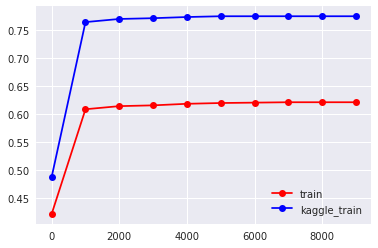

In [9]:
x = np.arange(0,10000,1000)
print("train")
plt.plot(x,list_train_acc,'or-',label = "train")
plt.plot(x,list_train_kaggle_acc,'ob-',label = "kaggle_train")
plt.legend()

train


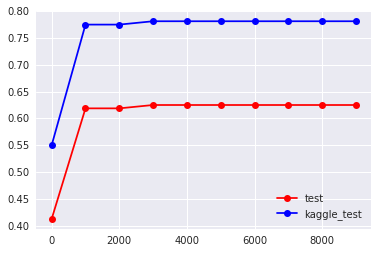

In [11]:
x = np.arange(0,10000,1000)
print("train")
plt.plot(x,list_test_acc,'or-',label = "test")
plt.plot(x,list_test_kaggle_acc,'ob-',label = "kaggle_test")
plt.legend()